# Multi-layer Feedforward Neural Network in TF-Slim
*by Marvin Bertin*
<img src="../images/tensorflow.png" width="400">

### Lesson Goals
- Generate synthetic 2D data for a 3-class classification task
- Build a 3-Layer Feedforward Neural Network
- Train and evaluate neural network model
- Visualize learned decision boundary

## Imports

In [1]:
import matplotlib
import seaborn as sns
%matplotlib inline

sns.set_style(style='white')
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
slim = tf.contrib.slim

%load_ext autoreload
%autoreload 2

## Import Helper Function

In [2]:
import sys  
sys.path.append("../")

from utils.data_generator import SpiralDataset

## Generate Spiral Dataset

In [3]:
spiral_data = SpiralDataset()
# training set with noise
train_dataset = spiral_data.generate_spiral_dataset(points_per_class=200, noise=0.5)
# test set with noise
test_dataset = spiral_data.generate_spiral_dataset(points_per_class=100, noise=0.5)

print("X_train shape: ", train_dataset['X'].shape)
print("y_train shape: ", train_dataset['y'].shape)

X_train shape:  (600, 2)
y_train shape:  (600,)


## Plot Train and Test Dataset
The data pattern is evident, but the added noise makes some data points ambiguous to classify. How will a neural network be able to deal with uncertainty?

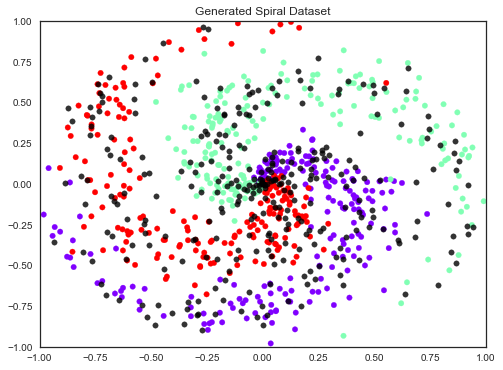

In [4]:
spiral_data.plot_spiral(train_dataset['X'], train_dataset['y'], test_dataset['X'])

## 3-Layer Feedforward Neural Network

```
with slim.arg_scope([slim.fully_connected],
                    activation_fn=tf.nn.relu,
                    weights_regularizer=slim.l2_regularizer(weight_decay)):

    # fc1
    net = slim.fully_connected(inputs, 64, scope='fc1')
    # fc2
    net = slim.fully_connected(net, 32, scope='fc2')
    # fc3 layer is made linear by setting activation_fn=None overriding the arg_scope
    net = slim.fully_connected(net, 3, activation_fn=None, scope='prediction')
```

## Build Neural Network and Inspect Model Structure

In [5]:
from utils.slim_models import DeepClassifier

input_dim, output_dim = (2,), 3
deep_classifier_model = DeepClassifier(input_dim, output_dim)
deep_classifier_model.examine_model_structure()

Layers
name = deep_classifier/fc1/Relu:0                              shape = (?, 64)
name = deep_classifier/fc2/Relu:0                              shape = (?, 32)
name = deep_classifier/prediction/BiasAdd:0                    shape = (?, 3)


Parameters
name = deep_classifier/fc1/weights:0                           shape = (2, 64)
name = deep_classifier/fc1/biases:0                            shape = (64,)
name = deep_classifier/fc2/weights:0                           shape = (64, 32)
name = deep_classifier/fc2/biases:0                            shape = (32,)
name = deep_classifier/prediction/weights:0                    shape = (32, 3)
name = deep_classifier/prediction/biases:0                     shape = (3,)


## Import Training Helper Function
The details of the training routing for a neural net will be covered in a later lesson. For now, we will just use it to train our model.

In [6]:
from utils.slim_training_evaluation import ModelTrainerEvaluater
from utils.slim_data_provider import DatasetProvider
checkpoint_dir="../models/deep_classifier/"

deep_classifier_trainer = ModelTrainerEvaluater(model = deep_classifier_model,
                                                dataset_provider = DatasetProvider(),
                                                data_name = "spiral",
                                                checkpoint_dir = checkpoint_dir)

## Run Training with Train Dataset

In [8]:
deep_classifier_trainer.train(dataset=train_dataset,
                              weight_decay=0.005,
                              learning_rate=0.05,
                              iterations=1000,
                              log_frq=100)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global step 100: loss = 0.4703 (0.00 sec/step)
INFO:tensorflow:global step 200: loss = 0.4527 (0.00 sec/step)
INFO:tensorflow:global step 300: loss = 0.4600 (0.00 sec/step)
INFO:tensorflow:global step 400: loss = 0.4438 (0.00 sec/step)
INFO:tensorflow:global step 500: loss = 0.4404 (0.00 sec/step)
INFO:tensorflow:global step 600: loss = 0.4403 (0.00 sec/step)
INFO:tensorflow:global step 700: loss = 0.4401 (0.00 sec/step)
INFO:tensorflow:global step 800: loss = 0.4380 (0.00

## Run Evaluation on Train Dataset
The details of the evaluation routing will be covered in a later lesson. For now, we will just use it to evaluate the performance of our model.

In [9]:
deep_classifier_trainer.evaluate(num_evals=1, dataset=train_dataset)

Running evaluation Loop...
INFO:tensorflow:Starting evaluation at 2017-03-05-00:28:43
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-03-05-00:28:44
eval/Precision: 0.946341
eval/Accuracy: 0.923333
eval/Recall@3: 1.000000
eval/Recall: 0.970000


## Reload Model Parameters for Inference Prediction Task
Once the model is trained, predictions are made by loading the saved model parameters and performing inference. The model is only run forwards (no backpropagation, nor parameter updating).

In [10]:
from utils.slim_data_provider import DatasetProvider

def get_accuracy(dataset, model):
    with tf.Graph().as_default():
        data_provider = DatasetProvider()
        
        # load data into TensorFlow tensor objects
        inputs, targets = data_provider.load_batch_spiral(dataset)

        # running inference on the model graph
        logits, end_points = model.graph(inputs)
        
        # making predictions
        predictions = tf.argmax(logits, 1)
        
        # computing accuracy
        accuracy = slim.metrics.accuracy(predictions, targets)

        # Make a session which restores the old parameters from a checkpoint.
        sv = tf.train.Supervisor(logdir = checkpoint_dir)
        with sv.managed_session() as sess:
            preds, acc = sess.run([predictions, accuracy])
    return [preds, acc]

## Train Accuracy

In [11]:
_, train_accuracy = get_accuracy(train_dataset, deep_classifier_model)
print("Train accuracy: ", train_accuracy)

Train accuracy:  0.923333


## Test Accuracy

In [12]:
_, train_accuracy = get_accuracy(test_dataset, deep_classifier_model)
print("Test accuracy: ", train_accuracy)

Test accuracy:  0.93


## Plotting Learned Decision Boundary
Decision boundary is overlaid into training set.

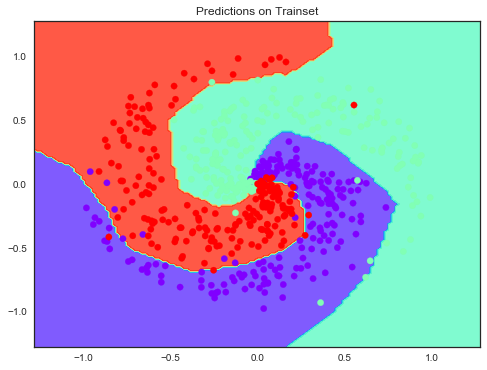

In [13]:
spiral_data.plot_classifier(deep_classifier_model,
                            train_dataset,
                            checkpoint_dir,
                            title = "Predictions on Trainset")

Decision boundary is overlaid into test set.

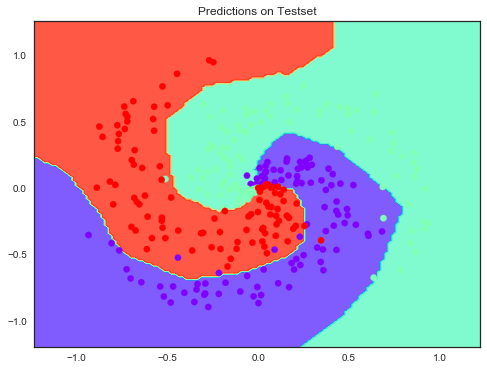

In [14]:
spiral_data.plot_classifier(deep_classifier_model,
                            test_dataset,
                            checkpoint_dir,
                            title = "Predictions on Testset")

## Next Lesson
### Deep Convolutional Neural Network for image classification in TensorFlow-Slim
-  Define Deep Convolutional Neural Network for classification task on image dataset.

<img src="../images/divider.png" width="100">